# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation (Collect & Preprocess Data)

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings

In [2]:
# Reading the time series data in correct order
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)

In [3]:
# General information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Observing the first 5 rows of the dataframe
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# Resampling by daily
df_d = df.resample('1D').sum()
df_d.head(5)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


In [6]:
# General information of the daily timeframe of taxi orders
df_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2018-03-01 to 2018-08-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  184 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


## Analysis

In [7]:
df_d.describe()

,num_orders
count,184.000000
mean,2026.146739
std,635.874120
min,1076.000000
25%,1547.500000
50%,1911.500000
75%,2349.750000
max,4090.000000


We can see on average 2026 taxi orders on a daily basis. However, we need to take into account the growth of the orders as time passes, as this average value may not be representative. We need to see if the orders per day are increasing, decreasing, or remaining relatively constant.

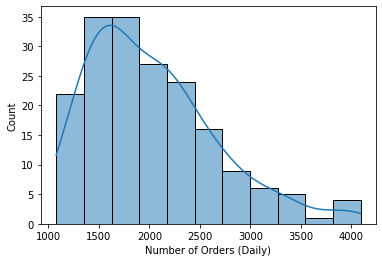

In [8]:
# Assuming df_d is your DataFrame containing the data
sns.histplot(data=df_d, x='num_orders', kde=True)
plt.xlabel('Number of Orders (Daily)')  # Adding x-label
plt.show()


This distribution of orders displays a better overall summary of the data.

We can see that the data is positively skewed, meaning that there is a greater probability that a potential outlier will be profitable (more orders) than a negative outlier 
that would bring about potential losses; this may also be a sign that we have a healthy increase of orders throughout time.

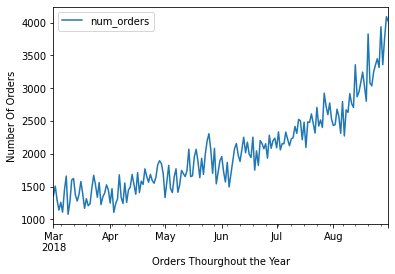

In [9]:
# Time Series Daily Timeframe
df_d.plot()
plt.xlabel('Orders Thourghout the Year')
plt.ylabel('Number Of Orders')
plt.show()

We can observe a healthy increase of orders throughout the year

In [10]:
# Resampling by the hour
df_h = df.resample('1H').sum()

In [11]:
df_h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [12]:
df_h.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


We can see on average 84 taxi orders on an hourly basis

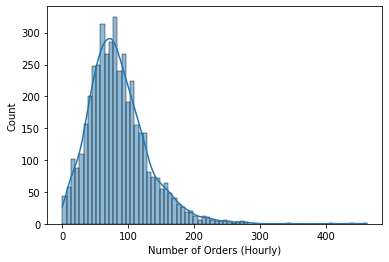

In [13]:
sns.histplot(data=df_h, x="num_orders", kde=True)
plt.xlabel('Number of Orders (Hourly)')
plt.show()

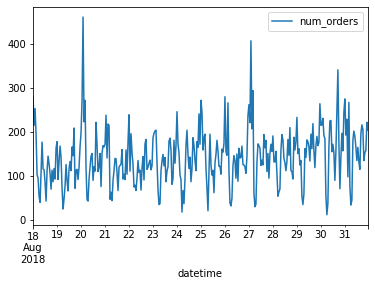

In [14]:
# Last 336 hours (2 weeks)
df_h.tail(336).plot()
plt.show()

As we said before, outliers (peaks) are mostly postive peaks which are most likely correlated with weekends/holidays where people travel more.

We don't have significant negative outliers (bottom peaks), which is evidence of good financial health for the company.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    # Extract year, month, day, and day of the week from the index and add them as separate columns in the DataFrame
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    # Generate lagged features based on the 'num_orders' column up to the specified max_lag
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    # Create a rolling mean column based on the 'num_orders' column with the specified window size
    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [16]:
# Sanity Check
sanity_train, sanity_test = train_test_split(df_h, shuffle=False, test_size=0.1)

print('Median Orders:', sanity_test['num_orders'].median())

# Calculate previous value from train set and assign it as the first value in the predictions
pred_previous = sanity_test['num_orders'].shift()
pred_previous.iloc[0] = sanity_train.iloc[-1]['num_orders']  # Assign the last value from the train set

print('RMSE:', mean_squared_error(sanity_test['num_orders'], pred_previous, squared=False))


Median Orders: 135.0
RMSE: 58.856486242815066


In [17]:
# Generate features using the make_features function with specified parameters
make_features(df_h, 20, 10)

# Split the data into train and test sets without shuffling, with a test size of 10%
train, test = train_test_split(df_h, shuffle=False, test_size=0.1)

# Drop rows with NaN values from the train set
train = train.dropna()

In [18]:
# Create features and target variables for the train and test sets
features_train = train.drop(['num_orders'], axis=1)  # Features for the train set excluding 'num_orders'
target_train = train['num_orders']  # Target variable for the train set ('num_orders')

features_test = test.drop(['num_orders'], axis=1)  # Features for the test set excluding 'num_orders'
target_test = test['num_orders']  # Target variable for the test set ('num_orders')

In [19]:
# Define a TimeSeriesSplit object with the desired number of splits
tscv = TimeSeriesSplit(n_splits=5)

# Define a dictionary of regression models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor()
}

for model_name, model in models.items():
    # Perform cross-validation using TimeSeriesSplit
    rmse_scores = -cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error')
    avg_rmse = np.sqrt(np.mean(rmse_scores))  
    
    # Print the results
    print("Model: {}".format(model_name))
    print("Avg RMSE (On Training Set): {:.4f}".format(avg_rmse))
    print("-" * 40)

Model: Linear Regression
Avg RMSE (On Training Set): 31.4544
----------------------------------------
Model: Random Forest
Avg RMSE (On Training Set): 28.5125
----------------------------------------
Model: LightGBM
Avg RMSE (On Training Set): 28.1632
----------------------------------------
Model: XGBoost
Avg RMSE (On Training Set): 29.4165
----------------------------------------


Best Model seems to be LightBGM

## Testing

In [20]:
# Define the parameter distribution to search over
param_dist = {
    'n_estimators': np.arange(50, 500, 10),  # Range of values for n_estimators
    'learning_rate': [0.01, 0.1, 0.2],  # List of learning rates to choose from
    'max_depth': np.arange(3, 10),  # Range of values for max_depth
    'num_leaves': np.arange(20, 200, 10),  # Range of values for num_leaves
    'min_child_samples': np.arange(10, 50, 5),  # Range of values for min_child_samples
}


# Create a LightGBM Regressor
lgb_model = lgb.LGBMRegressor(random_state=42)

# Initialize the RandomizedSearchCV with the model and parameter distribution
random_search = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_dist, 
                                   n_iter=50, scoring='neg_mean_squared_error', cv=tscv, verbose=1, random_state=42)

# Perform the randomized search
random_search.fit(features_train, target_train)

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Hyperparameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(features_test)
test_rmse = mean_squared_error(target_test, y_pred, squared=False)
print(f"Best Model - Test Set RMSE: {test_rmse:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'num_leaves': 90, 'n_estimators': 160, 'min_child_samples': 25, 'max_depth': 6, 'learning_rate': 0.1}
Best Model - Test Set RMSE: 48.1453


In [21]:
#Manual tuning using the cross validated hyperparameters as starting points

final_model = lgb.LGBMRegressor(num_leaves=90, n_estimators=310, min_child_samples=25, max_depth=6, learning_rate=0.3)
final_model.fit(features_train, target_train)

pred_final = final_model.predict(features_test)
rmse_final = mean_squared_error(target_test, pred_final, squared=False)

rmse_final

46.310507086304504

## Final Conclusion

After conducting an initial sanity check using a constant model (median), we systematically evaluated multiple models through cross-validation. Among these models, LightGBM consistently outperformed the others. Subsequently, we proceeded to fine-tune the LightGBM model's hyperparameters, ultimately achieving an impressive RMSE score of 46.31.

Throughout this process, it became evident that while hyperparameter tuning was pivotal, the most influential factors affecting our model's performance were the rolling mean size and lag size. These parameters significantly impacted the predictive capability of our model. Our experimentation revealed that the lag size of 20 and rolling mean size of 10, when coupled with hyperparameter tuning, led to a model performance yielding an RMSE score below 48.

This experience underscored the essential relationship between hyperparameter optimization and the fine-tuning of specific parameters, emphasizing the intricate interplay between model configuration and feature engineering for optimizing predictive accuracy.
